In [1]:
import numpy as np
import os
import pickle

from scipy.io import readsav

import matplotlib.pyplot as plt
import matplotlib.dates as date
from datetime import datetime
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cmasher as cmr

In [2]:
import scienceplots
plt.rcParams.update({'font.size': 14})
plt.style.use(['bright'])

Import Si IV data

In [3]:
pickle_file = 'siiv_spectra.pkl'

with open(pickle_file, 'rb') as f:
        loaded_data = pickle.load(f)

dat = loaded_data['dat']
wvl = loaded_data['wvl']
err = loaded_data['err']
arcsec = loaded_data['arcsec']
t_iris = loaded_data['t_iris']
time_iris = loaded_data['time_iris']
tm_iris = loaded_data['tm_iris']

In [4]:
# wavelength reductions
siiv_cen = 1402.77

x1,x2 = 1402.25,1404.25 
wvl_lim, = np.where((wvl >= x1) & (wvl <= x2))
lam = wvl[wvl_lim]
siiv = dat[:,:,wvl_lim]
siiv_err = err[:,:,wvl_lim]

dlam=np.unique(np.diff(lam))[0]
print('dlam: ',dlam)

dlam:  0.02543999999738844


Moment Calculation:

In [5]:
l1,l2 = 1401.5,1404. 
wvl_lim, = np.where((wvl >= l1) & (wvl <= l2))
lam_sub = wvl[wvl_lim]
siiv_sub = dat[:,:,wvl_lim]

In [6]:
Npx,Ntm = siiv.shape[0],siiv.shape[1]
m0 = np.zeros((Npx,Ntm))
m1 = np.full((Npx, Ntm), siiv_cen)
m2 = np.zeros((Npx,Ntm))
m3 = np.zeros((Npx,Ntm))


for j in range(0,Ntm):
    for i in range(0,Npx):
        
        yt = np.copy(siiv_sub[i,j])
        yt[yt<25]=0.0
        
        zeros = np.zeros(shape=yt.shape)
        if yt.min()==-200.: yt = zeros
        
        
        # define moments
        m0t = np.sum( yt ) * dlam
        if m0t<1.: 
            m0t=1.
            m1t=siiv_cen
        else:
            m1t = np.sum( yt*lam_sub )/m0t * dlam
        
        m0[i,j] = m0t
        m1[i,j] = m1t
        m2[i,j] = np.sum( yt*(lam_sub-m1t)**2 )/m0t * dlam
        m3[i,j] = np.sum( yt*(lam_sub-m1t)**3 )/m0t * dlam
    

Conversions:

In [7]:
vel = (m1-siiv_cen)/siiv_cen*3e5 # Doppler 

# thermal width
thermal_wid=[4.9,28.]
th_temp=10.**thermal_wid[0]
th_massnum=thermal_wid[1]* 1.661e-27 #SI


kb = 1.381e-23 #SI
c = 3e5 #; km/s conversion
th_wid =  siiv_cen * np.sqrt( kb * (th_temp) / th_massnum)/(c*1e3)
th_fwhm = np.sqrt(8*np.log(2))*th_wid
th_wid_vel = 0.5/np.sqrt(np.log(2.))*3e5/siiv_cen*th_fwhm 
print('thermal width: ',th_wid, ' = ', th_wid_vel, 'km/s')

# instrumental width 
iris_wid = 0.026

# quadrature - Single
m2[m2<0] = 0.0
fwhm = 2.*np.sqrt(2.*np.log(2.)) * np.sqrt(m2)
chck = fwhm**2 - iris_wid**2 - th_wid**2
chck[chck<0]=0.
w_nth = np.sqrt(chck)

thermal width:  0.022709011071788025  =  6.868280212537351 km/s


In [8]:
m0[m0<5]=1.0
vel[m0<5]=0.0
fwhm[m0<5]=th_fwhm

stackplots

(255.0, 270.0)

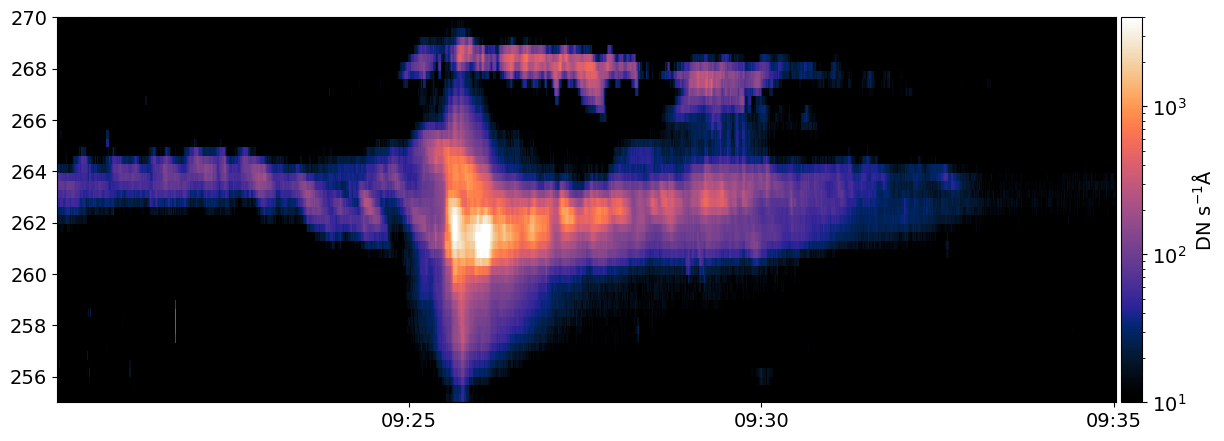

In [9]:
fig, ax = plt.subplots(figsize=(14,5))

im = ax.imshow(m0,origin='lower',norm=LogNorm(vmin=10, vmax=4000),cmap=cmr.torch,aspect='auto',interpolation='None',
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'DN s$^{-1} \mathrm{\AA}$')

# date stuff
ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)

ax.set_ylim(255,270)

(255.0, 270.0)

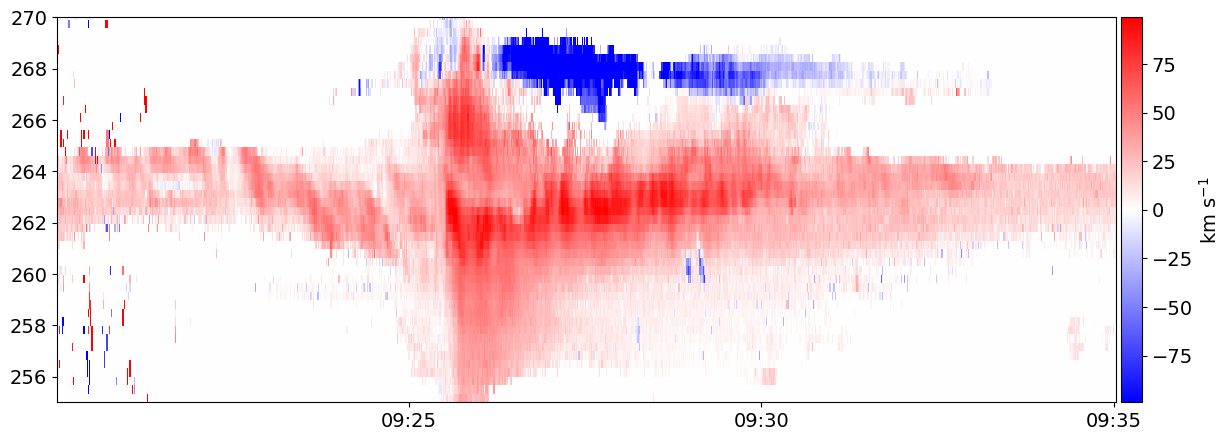

In [10]:
fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(vel ,vmin=-99, vmax=99, origin='lower',aspect='auto',cmap='bwr',interpolation='None',
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('km s$^{-1}$')

# date stuff
ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)

ax.set_ylim(255,270)

(255.0, 270.0)

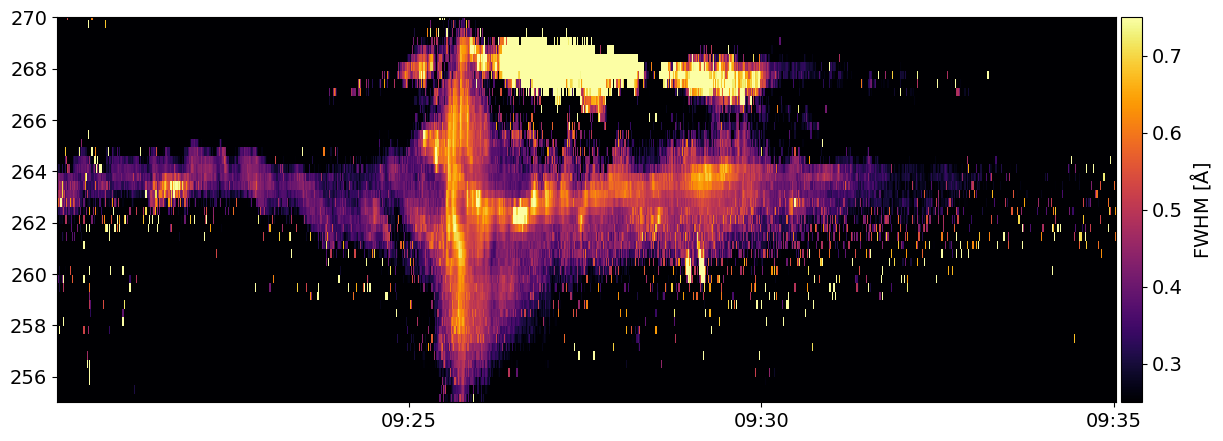

In [11]:
fig, ax = plt.subplots(figsize=(14,5))
im = ax.imshow(fwhm ,vmin=0.25, vmax=0.75, origin='lower',aspect='auto',cmap='inferno',interpolation='None',
          extent=[tm_iris[0],tm_iris[-1],arcsec[0],arcsec[-1]])

# color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'FWHM [$\mathrm{\AA}$]')

# date stuff
ax.xaxis_date()
date_format = date.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)

ax.set_ylim(255,270)